epoch:    0
total_size: 2233, acc_size: 1874, acc: 0.839
pos_size: 359, pos_acc_size: 0, pos_acc: 0.000
neg_size: 1874, neg_acc_size: 1874, neg_acc: 1.000
epoch:    1
epoch:    2
epoch:    3
epoch:    4
epoch:    5
epoch:    6
epoch:    7
epoch:    8
epoch:    9
epoch:   10
total_size: 2233, acc_size: 1904, acc: 0.853
pos_size: 359, pos_acc_size: 36, pos_acc: 0.100
neg_size: 1874, neg_acc_size: 1868, neg_acc: 0.997
epoch:   11
epoch:   12
epoch:   13
epoch:   14
epoch:   15
epoch:   16
epoch:   17
epoch:   18
epoch:   19
epoch:   20
total_size: 2233, acc_size: 1987, acc: 0.890
pos_size: 359, pos_acc_size: 123, pos_acc: 0.343
neg_size: 1874, neg_acc_size: 1864, neg_acc: 0.995
epoch:   21
epoch:   22
epoch:   23
epoch:   24
epoch:   25
epoch:   26
epoch:   27
epoch:   28
epoch:   29
epoch:   30
total_size: 2233, acc_size: 2048, acc: 0.917
pos_size: 359, pos_acc_size: 218, pos_acc: 0.607
neg_size: 1874, neg_acc_size: 1830, neg_acc: 0.977
epoch:   31
epoch:   32
epoch:   33
epoch:   34
epo

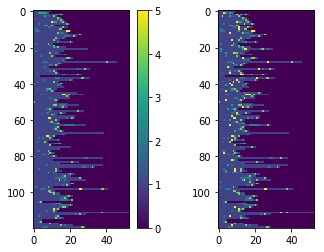

In [1]:
# %load "bp_test.py"

import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import bp_input

# batch size
batch_size = 5
# input vector size
hidden_size = 300
# unroll rnn with truncated bp,
# with a fixed number of number(num_step) cells
num_steps = 53
# forget bias
forget_bias = 1.0
# keep probability
keep_prob = 1.0
# num of layers in multiple layer lstm
num_layers = 2
# num of output classes 
num_classes = 6
# max epoch
max_epoch = 100

# input data
(tr_d, tr_l), (te_d, te_l) = bp_input.bp_raw_data(test_size=10)

#test_input = bp_input.BPInput(batch_size, te_d, te_l)
#inputs, labels, epoch_size = test_input.inputs, test_input.targets, test_input.epoch_size

train_input = bp_input.BPInput(batch_size, tr_d, tr_l)
inputs, labels, epoch_size = train_input.inputs, train_input.targets, train_input.epoch_size

inputs = tf.unstack(inputs, num=num_steps, axis=1)


# inference
# forward lstm layer
lstm_fw = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, forget_bias=forget_bias)

lstm_fw = tf.contrib.rnn.DropoutWrapper(lstm_fw, output_keep_prob=keep_prob)

multi_lstm_fw = tf.contrib.rnn.MultiRNNCell([lstm_fw] * num_layers)

initial_state_fw = multi_lstm_fw.zero_state(batch_size, tf.float32)

# backward lstm layer
lstm_bw = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_size, forget_bias=forget_bias)

lstm_bw = tf.contrib.rnn.DropoutWrapper(lstm_bw, output_keep_prob=keep_prob)

multi_lstm_bw = tf.contrib.rnn.MultiRNNCell([lstm_bw] * num_layers)

initial_state_bw = multi_lstm_bw.zero_state(batch_size, tf.float32)

# bilstm
outputs, output_state_fw, output_state_bw = tf.contrib.rnn.static_bidirectional_rnn(cell_fw=multi_lstm_fw, cell_bw=multi_lstm_bw, inputs=inputs, initial_state_fw = initial_state_fw, initial_state_bw = initial_state_bw,dtype=tf.float32)

# softmax layer
softmax_w = tf.get_variable("softmax_w", [2*hidden_size, num_classes], dtype=tf.float32)
softmax_b = tf.get_variable("softmax_b", [num_classes], dtype=tf.float32)

# output layer
output = tf.reshape(tf.concat(outputs, 1), [-1, 2 * hidden_size])
logits = tf.matmul(output, softmax_w) + softmax_b

# weights for different label 
label_flat = tf.reshape(labels, [-1])
weights = tf.to_float(tf.clip_by_value(label_flat, clip_value_min=0, clip_value_max=2))
weights = tf.square(weights)
mask = tf.sign(weights)

# loss and cost
loss = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
    logits=[logits],
    targets=[label_flat],
    weights=[mask])
cost = tf.reduce_sum(loss) / batch_size


# prediction
prediction = tf.argmax(logits, 1) * tf.to_int64(mask)

# analyse
def analyse(p, l, verbose=False):
    ppd = pd.DataFrame(p)
    lpd = pd.DataFrame(l)
    # all sample
    m = (lpd != 0) 
    total_size = m.sum().sum()
    acc_size = ((ppd == lpd) & m).sum().sum()
    acc = 1.0 * acc_size / total_size
    # pos sample
    m2 = (lpd > 1)
    pos_size = m2.sum().sum()
    pos_p = lpd[((ppd == lpd) & m2)]
    pos_acc_size = ((ppd == lpd) & m2).sum().sum()
    pos_acc = 1.0 * pos_acc_size / pos_size
    # neg sample
    neg_size = total_size - pos_size
    neg_acc_size = acc_size - pos_acc_size
    neg_acc = 1.0 * neg_acc_size / neg_size
    # print to screen
    if verbose:
        print("total_size: %d, acc_size: %d, acc: %.3f" % (total_size, acc_size, acc))
        print("pos_size: %d, pos_acc_size: %d, pos_acc: %.3f" % (pos_size, pos_acc_size, pos_acc))
        print("neg_size: %d, neg_acc_size: %d, neg_acc: %.3f" % (neg_size, neg_acc_size, neg_acc))
    return acc, pos_acc, neg_acc

# draw
def draw(p, l):
    assert p.shape == l.shape
    f1 = plt.subplot(121)
    i1 = f1.imshow(p, vmin=0, vmax=5)
    plt.colorbar(i1)
    f2 = plt.subplot(122)
    i2 = f2.imshow(l, vmin=0, vmax=5)
    plt.show()
    
    
# run an epoch
def run_epoch(sess):
    start_time = time.time()
    costs = 0.0
    iters = 0.0
    # zero state
    state_fw = sess.run(initial_state_fw)
    state_bw = sess.run(initial_state_bw)
    
    preds = []
    for step in range(epoch_size):
        # construct feed_dict
        feed_dict = {}
        for i, (c, h) in enumerate(initial_state_fw):
            feed_dict[c] = state_fw[i].c
            feed_dict[h] = state_fw[i].h
        for i, (c, h) in enumerate(initial_state_bw):
            feed_dict[c] = state_bw[i].c
            feed_dict[h] = state_bw[i].h
        # 
        c, state_fw, state_bw, pred = sess.run(
            [cost, output_state_fw, output_state_bw, prediction],
            feed_dict)
        # 
        costs += c
        iters += num_steps
        preds.append(pred)
        #if step % (epoch_size // 10) == 0:
        #    print("%.3f perplexity: %.3f speed: %.0f wps" %
        #        (step * 1.0 / epoch_size, np.exp(costs / iters),
        #         iters * batch_size / (time.time() - start_time)))
    preds = np.vstack(preds).reshape(-1, 53)
    return preds


# saver 
saver = tf.train.Saver(tf.trainable_variables(), max_to_keep=None)

# saver path 
if not os.path.exists("ckpt_files"):
    os.mkdir("ckpt_files")
ckpt_path = "ckpt_files/model.ckpt"

# session 
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# coord for threads 
coord = tf.train.Coordinator()

threads = tf.train.start_queue_runners(sess=sess, coord=coord)

accs = []

# train several epoches
for i in range(max_epoch):
    print("epoch: %4d" % i)
    if i % 10 == 0 or i + 1 == max_epoch:
        #saver.save(sess, ckpt_path, global_step=i, write_meta_graph=False)
        saver.restore(sess, ckpt_path + "-%d" % i)
        p = run_epoch(sess)
        acc = analyse(p, tr_l[: p.shape[0]], verbose=True)
        accs.append([acc])
    
# stop threads 
coord.request_stop()
# wait for all threads to stop
coord.join(threads)

draw(p, tr_l[: p.shape[0]])







In [2]:
acc = np.array(accs)


In [3]:
pd.DataFrame(acc.reshape(-1, 3))

,0,1,2
0,0.708609,0.00000,0.899160
1,0.708609,0.00000,0.899160
2,0.688742,0.03125,0.865546
3,0.655629,0.00000,0.831933
4,0.675497,0.03125,0.848739
5,0.675497,0.06250,0.840336
6,0.688742,0.06250,0.857143
7,0.682119,0.03125,0.857143
8,0.668874,0.06250,0.831933
9,0.662252,0.03125,0.831933


In [14]:
accs1 = []

In [15]:
for i in range(10):
    print("epoch: %4d" % i)
    if i % 1 == 0 or i + 1 == max_epoch:
        #saver.save(sess, ckpt_path, global_step=i, write_meta_graph=False)
        #saver.restore(sess, ckpt_path + "-%d" % i)
        p = run_epoch(sess)
        acc = analyse(p, tr_l[: p.shape[0]], verbose=True)
        accs1.append([acc])

epoch:    0


OutOfRangeError: FIFOQueue '_0_input_producer/fraction_of_32_full/fraction_of_32_full' is closed and has insufficient elements (requested 1, current size 0)
	 [[Node: fraction_of_32_full_Dequeue = QueueDequeueV2[component_types=[DT_INT32], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer/fraction_of_32_full/fraction_of_32_full)]]

Caused by op u'fraction_of_32_full_Dequeue', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-f2a998b6e88e>", line 36, in <module>
    train_input = bp_input.BPInput(batch_size, tr_d, tr_l)
  File "bp_input.py", line 41, in __init__
    i = tf.train.range_input_producer(self.epoch_size, shuffle=False).dequeue()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/data_flow_ops.py", line 427, in dequeue
    self._queue_ref, self._dtypes, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 1435, in _queue_dequeue_v2
    timeout_ms=timeout_ms, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

OutOfRangeError (see above for traceback): FIFOQueue '_0_input_producer/fraction_of_32_full/fraction_of_32_full' is closed and has insufficient elements (requested 1, current size 0)
	 [[Node: fraction_of_32_full_Dequeue = QueueDequeueV2[component_types=[DT_INT32], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer/fraction_of_32_full/fraction_of_32_full)]]
